In [1]:
import numpy as np              # numpy is a general-purpose math package
import yt                       # yt is the data vizualization package
from yt.units import *          # this lets you get things like speed of light in proper units just by typing 'c'
from astropy.table import Table # this is needed for reading in various foggie data byproducts
from astropy.io import ascii    # this too
import matplotlib.pyplot as plt # this is the standard python plotting package, very useful!
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import math
from ipynb.fs.defs.FRB_and_Projection_functions import frb_projection, projection
from scipy import optimize
import pwlf # A library for fitting continuous piecewise linear functions to data (Returns cut-off radius)
import os #for the lacie part 

# These imports are FOGGIE-specific files
from foggie.utils.consistency import *
from foggie.utils.foggie_load import *

home_dir = '/Users/hylee/foggie/'
laptop_root_dir = home_dir + 'foggie_sims/' # root directory where sims are stored on the laptop
hd_root_dir = '/Volumes/LaCie/' # root directory where sims are stored on the hard drive

root_dir = hd_root_dir # have this as either laptop_root_dir or hd_root_dir depending on where the simulation is stored
code_path = '/Users/hylee/coding/foggie/foggie/' #path to the cloned github repo

# everything above this is general path, and below this is specific to a given halo
halo = '8508' # which halo
simulation_dir = root_dir + 'halo_00' + halo + '/nref11c_nref9f/' # path where the foggie simulations are stored
output_dir = home_dir + 'foggie_output/halo_00' + halo + '/nref11c_nref9f/' # path where all the outputs will be stored
track_dir = code_path + 'halo_infos/00' + halo + '/nref11c_nref9f/'
track_name = code_path + 'halo_tracks/00' + halo + '/nref11n_selfshield_15/halo_track_200kpc_nref9' #these need to be provided to foggie_load()

In [2]:
def radius_func(od, size, res):
    OD_Qua=[]
    OD_Rad=[]  #OD_Rad & OD_Met HAVE to be defined specifically inside func1/before for loop
    for i in range(70):
        for j in range(70):
            this_quantity_value = od[i][j]
            xindex = i
            yindex = j
            radius = (math.sqrt(((yindex-34)**2+(xindex-34)**2)))*(size/res)
            OD_Qua.append(this_quantity_value)
            OD_Rad.append(radius)
    return OD_Rad, OD_Qua

In [3]:
def binning_func(OD_Rad, OD_Qua, max_radius, min_radius, binsize):
    index = 0 
    quantitylist = []
    sort = np.argsort(OD_Rad)
    sorted_radius = np.array(OD_Rad)[sort]
    sorted_quantity = np.array(OD_Qua)[sort]
    radiuslist = np.arange(min_radius, max_radius, binsize) + binsize/2
    while index < len(radiuslist):
        left_edge = index*binsize
        right_edge = left_edge + binsize 
        new_quantity = np.array(sorted_quantity)[(left_edge <= sorted_radius) & (sorted_radius < right_edge)]
        quantitylist.append((np.mean(new_quantity)))
        index +=1
    return radiuslist, quantitylist

In [4]:
def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

In [5]:
def plotting(xvalue, yvalue_origdata, yvalue_cutoff, color_original, color_cutoff, plotlabel_linedot,
            plotlabel_segment):
    fig1 = plt.figure()
    plt.plot(xvalue, yvalue_origdata, color_original, label=plotlabel_linedot)
    plt.plot(xvalue, yvalue_cutoff, color_cutoff, label=plotlabel_segment)
    plt.legend(loc="upper right", fontsize = 15)
    plt.xlabel("Radius from galactic center [kpc]", fontsize = fontsize)
    plt.ylabel("Density [log 10 g/cm^2]", fontsize = fontsize)
    plt.xticks(fontsize = fontsize/1.5)
    plt.yticks(fontsize = fontsize/1.5)
    return fig1

In [6]:
def get_density_cut(current_time):
    t1, t2 = 8.628, 10.754 # Gyr; corresponds to z1 = 0.5 and z2 = 0.25
    rho1, rho2 = 2e-26, 2e-27 # g/cm**3
    t = np.float64(current_time)
    rho_cut = np.piecewise(t, [t < t1, (t >= t1) & (t <= t2), t > t2], [rho1, lambda t: rho1 + (t - t1) * (rho2 - rho1) / (t2 - t1), rho2])
    return rho_cut

In [7]:
DDLIST = []
for file in os.listdir(simulation_dir):
    if file.startswith("DD"):
        DDLIST.append(file)
sorted_dd_list = sorted(DDLIST, key=lambda x: int(x[2:]))

In [8]:
field = "density"
axis = "y" 
resolution = 70 #[pixel]
colorlabel = 'Density [log 10 g/cm^2]'
min_radius = 0  #[kpc]
binsize = 1.5 #[kpc]
markersize = 10
fontsize = 20 
plotlabel_linedot = 'Binned mean density'
plotlabel_segment = 'Fitted density'

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0138/DD0138


yt : [INFO     ] 2023-07-19 13:55:46,642 Parameters: current_time              = 67.566527818285
yt : [INFO     ] 2023-07-19 13:55:46,643 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 13:55:46,644 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 13:55:46,647 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 13:55:46,649 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-19 13:55:46,650 Parameters: current_redshift          = 4.2560468529995
yt : [INFO     ] 2023-07-19 13:55:46,651 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-19 13:55:46,651 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-19 13:55:46,652 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-19 13:55:46,653 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:     col1      col2     col3     col4     col5     col6     col7   col8
----------- -------- -------- -------- -------- -------- -------- ----
4.256046853 0.494908 0.492937 0.500048 0.496908 0.494937 0.502048    9


Parsing Hierarchy : 100%|█████████████████| 5116/5116 [00:00<00:00, 6953.71it/s]
yt : [INFO     ] 2023-07-19 13:55:47,737 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 13:57:08,648 Projection completed
yt : [INFO     ] 2023-07-19 13:57:08,650 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/var/folders/d8/fhyrhkwj0gn9mv61yhxy4srw0005m7/T/ipykernel_66655/2204027200.py:26: RuntimeWarning: divide by zero encountered in log10
  p , e = optimize.curve_fit(piecewise_linear, radiuslist, np.log10(quantitylist))
yt : [INFO     ] 2023-07-19 13:57:08,740 Parameters: current_time              = 92.566527818285
yt : [INFO     ] 2023-07-19 13:57:08,740 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 13:57:08,741 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 13:57:08,742 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 13:57:08,742 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-19 13:57:08,743 Parameters: current_redshift          = 3.2538800161868
yt : [INFO     ] 2023-07-19 13:57:08,744 Parameters: omeg

Error with DD0138
Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0238/DD0238
get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
3.25388001619 0.494301 0.491267 0.500132 0.496301 0.493267 0.502132    9


Parsing Hierarchy : 100%|██████████████| 11675/11675 [00:01<00:00, 11335.74it/s]
yt : [INFO     ] 2023-07-19 13:57:10,112 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 14:00:00,734 Projection completed
yt : [INFO     ] 2023-07-19 14:00:00,735 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


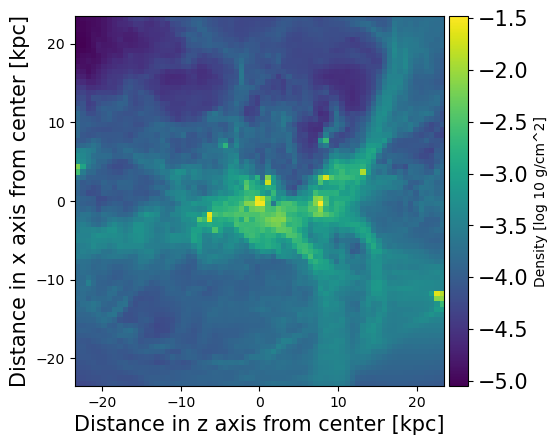

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0287/DD0287


yt : [INFO     ] 2023-07-19 14:00:01,406 Parameters: current_time              = 104.81652781829
yt : [INFO     ] 2023-07-19 14:00:01,407 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 14:00:01,408 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 14:00:01,409 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 14:00:01,410 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-19 14:00:01,411 Parameters: current_redshift          = 2.9116806075987
yt : [INFO     ] 2023-07-19 14:00:01,411 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-19 14:00:01,412 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-19 14:00:01,413 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-19 14:00:01,414 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:     col1       col2     col3     col4     col5     col6     col7   col8
------------ -------- -------- -------- -------- -------- -------- ----
2.9116806076 0.493954 0.490721 0.500203 0.495954 0.492721 0.502203    9


Parsing Hierarchy : 100%|████████████████| 7384/7384 [00:00<00:00, 11671.38it/s]
yt : [INFO     ] 2023-07-19 14:00:02,287 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 14:01:41,090 Projection completed
yt : [INFO     ] 2023-07-19 14:01:41,091 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


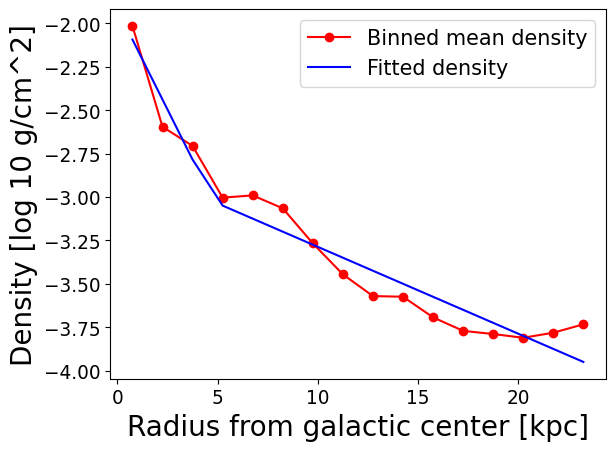

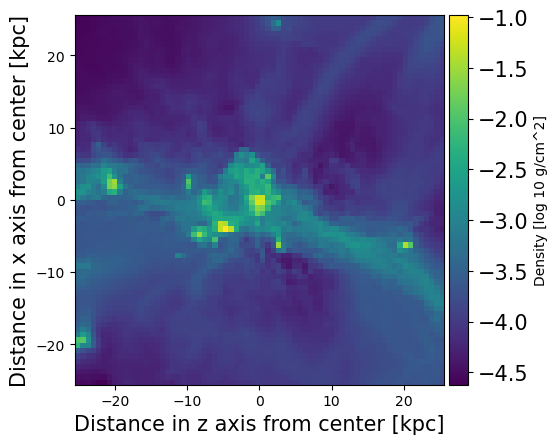

yt : [INFO     ] 2023-07-19 14:01:41,639 Parameters: current_time              = 106.31652781829
yt : [INFO     ] 2023-07-19 14:01:41,640 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 14:01:41,640 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 14:01:41,641 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 14:01:41,643 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-19 14:01:41,643 Parameters: current_redshift          = 2.8742891413864
yt : [INFO     ] 2023-07-19 14:01:41,644 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-19 14:01:41,645 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-19 14:01:41,645 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-19 14:01:41,646 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0293/DD0293
get_refine_box: using this location:      col1       col2     col3     col4    col5     col6     col7  col8
------------- -------- -------- ------- -------- -------- ------- ----
2.87428914139 0.493962 0.490687 0.50017 0.495962 0.492687 0.50217    9


Parsing Hierarchy : 100%|█████████████████| 7297/7297 [00:01<00:00, 6186.92it/s]
yt : [INFO     ] 2023-07-19 14:01:43,072 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 14:03:21,519 Projection completed
yt : [INFO     ] 2023-07-19 14:03:21,520 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


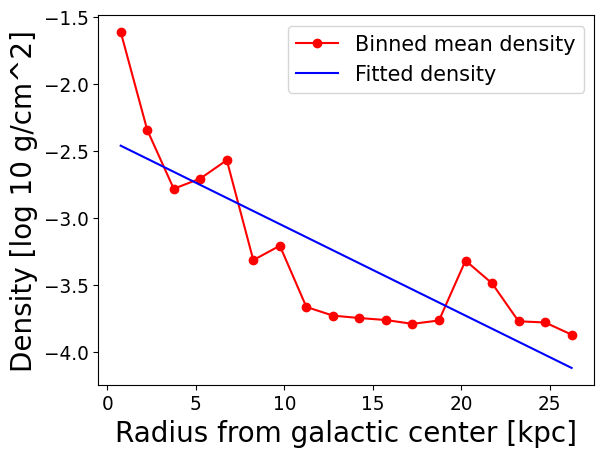

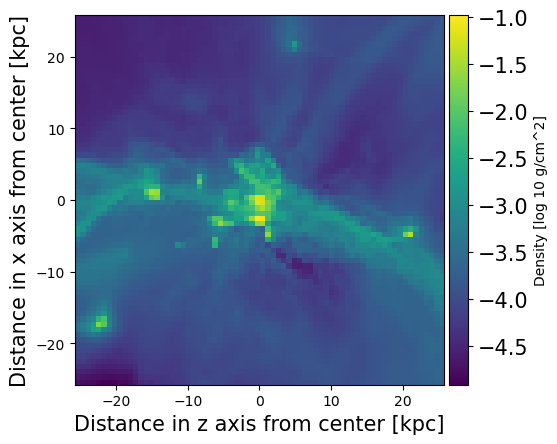

yt : [INFO     ] 2023-07-19 14:03:22,105 Parameters: current_time              = 117.56652781829
yt : [INFO     ] 2023-07-19 14:03:22,106 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 14:03:22,106 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 14:03:22,107 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 14:03:22,108 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-19 14:03:22,109 Parameters: current_redshift          = 2.6192132579666
yt : [INFO     ] 2023-07-19 14:03:22,109 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-19 14:03:22,110 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-19 14:03:22,111 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-19 14:03:22,112 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0338/DD0338
get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
2.61921325797 0.493773 0.490067 0.500353 0.495773 0.492067 0.502353    9


Parsing Hierarchy : 100%|█████████████████| 8624/8624 [00:00<00:00, 8908.70it/s]
yt : [INFO     ] 2023-07-19 14:03:23,440 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 14:05:24,632 Projection completed
yt : [INFO     ] 2023-07-19 14:05:24,633 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


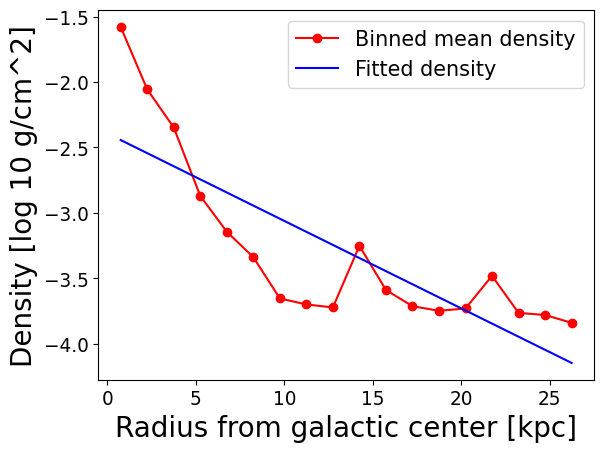

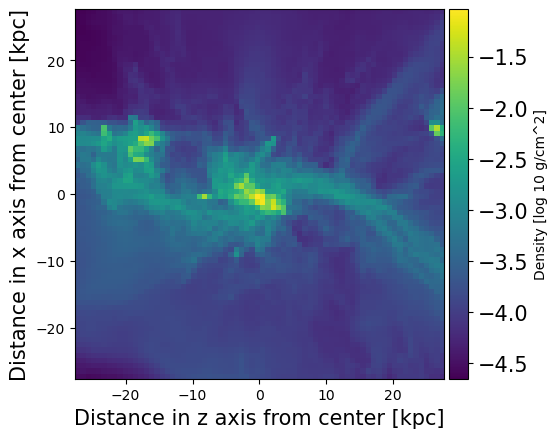

yt : [INFO     ] 2023-07-19 14:05:25,298 Parameters: current_time              = 142.56652781829
yt : [INFO     ] 2023-07-19 14:05:25,298 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 14:05:25,299 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 14:05:25,299 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 14:05:25,300 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-19 14:05:25,301 Parameters: current_redshift          = 2.174064272558
yt : [INFO     ] 2023-07-19 14:05:25,302 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-19 14:05:25,302 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-19 14:05:25,303 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-19 14:05:25,304 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0438/DD0438
get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
2.17406427256 0.493252 0.488579 0.500941 0.495252 0.490579 0.502941    9


Parsing Hierarchy : 100%|████████████████| 9619/9619 [00:00<00:00, 10939.71it/s]
yt : [INFO     ] 2023-07-19 14:05:26,514 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 14:07:29,650 Projection completed
yt : [INFO     ] 2023-07-19 14:07:29,652 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


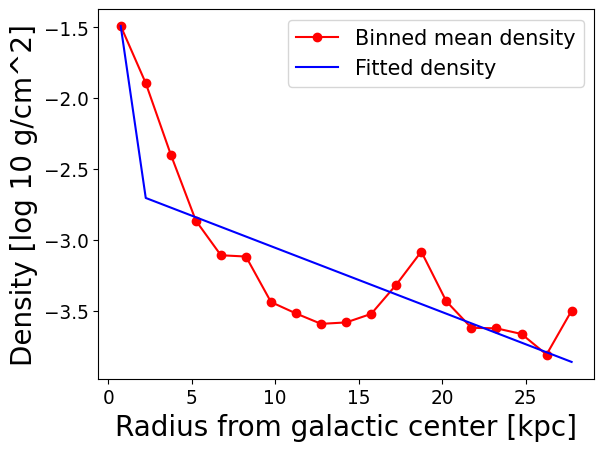

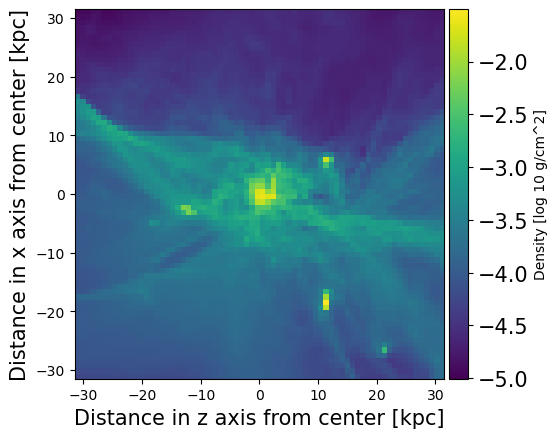

yt : [INFO     ] 2023-07-19 14:07:30,248 Parameters: current_time              = 167.56652781829
yt : [INFO     ] 2023-07-19 14:07:30,249 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 14:07:30,250 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 14:07:30,250 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 14:07:30,251 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-19 14:07:30,252 Parameters: current_redshift          = 1.8407728906142
yt : [INFO     ] 2023-07-19 14:07:30,253 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-19 14:07:30,254 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-19 14:07:30,254 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-19 14:07:30,255 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0538/DD0538
get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
1.84077289061 0.492796 0.487204 0.501442 0.494796 0.489204 0.503442    9


Parsing Hierarchy : 100%|█████████████████| 6003/6003 [00:00<00:00, 6030.57it/s]
yt : [INFO     ] 2023-07-19 14:07:31,498 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 14:08:52,359 Projection completed
yt : [INFO     ] 2023-07-19 14:08:52,360 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


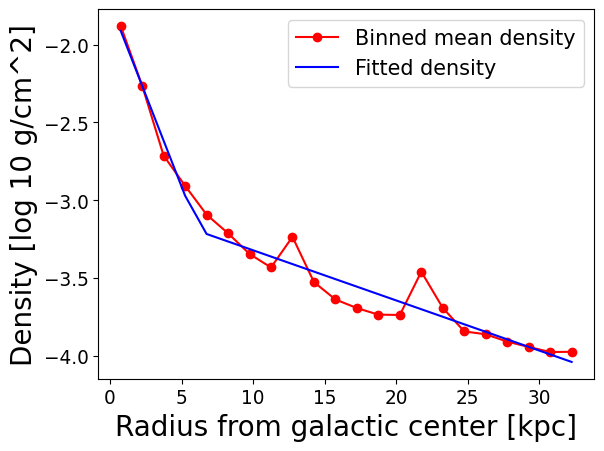

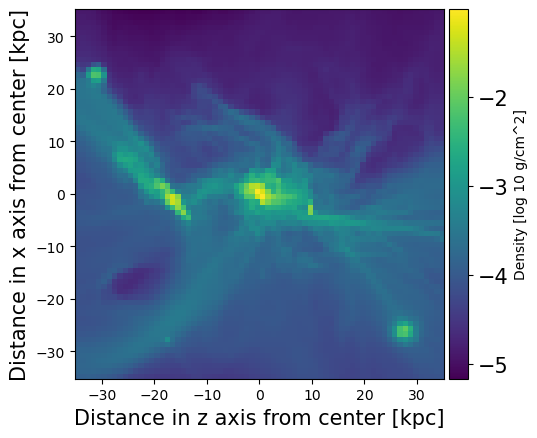

yt : [INFO     ] 2023-07-19 14:08:52,942 Parameters: current_time              = 192.56652781829
yt : [INFO     ] 2023-07-19 14:08:52,943 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 14:08:52,944 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 14:08:52,944 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 14:08:52,945 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-19 14:08:52,946 Parameters: current_redshift          = 1.5796008591072
yt : [INFO     ] 2023-07-19 14:08:52,947 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-19 14:08:52,947 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-19 14:08:52,948 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-19 14:08:52,949 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0638/DD0638
get_refine_box: using this location:      col1       col2    col3     col4     col5    col6     col7   col8
------------- ------- -------- -------- ------- -------- -------- ----
1.57960085911 0.49248 0.485831 0.501973 0.49448 0.487831 0.503973    9


Parsing Hierarchy : 100%|█████████████████| 7363/7363 [00:01<00:00, 4841.19it/s]
yt : [INFO     ] 2023-07-19 14:08:54,751 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 14:10:29,518 Projection completed
yt : [INFO     ] 2023-07-19 14:10:29,520 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


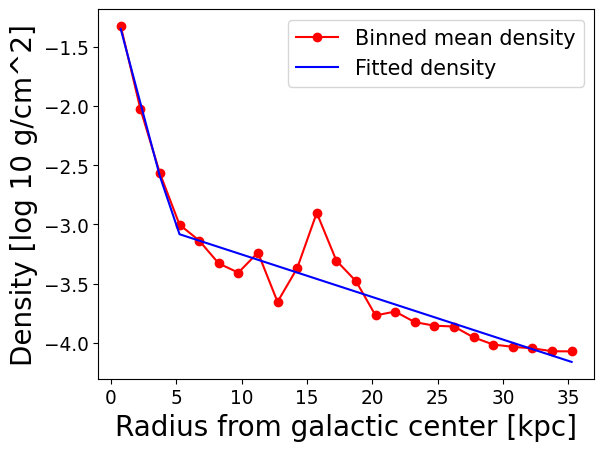

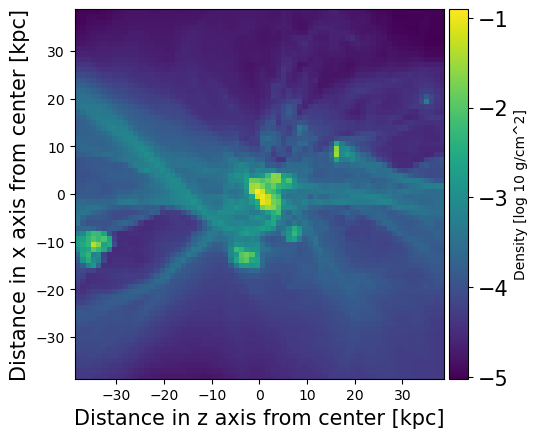

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0738/DD0738


yt : [INFO     ] 2023-07-19 14:10:30,282 Parameters: current_time              = 217.56652781829
yt : [INFO     ] 2023-07-19 14:10:30,283 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 14:10:30,284 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 14:10:30,285 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 14:10:30,286 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-19 14:10:30,287 Parameters: current_redshift          = 1.3679320867642
yt : [INFO     ] 2023-07-19 14:10:30,288 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-19 14:10:30,288 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-19 14:10:30,289 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-19 14:10:30,290 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:      col1       col2    col3     col4    col5    col6     col7  col8
------------- ------- -------- ------- ------- -------- ------- ----
1.36793208676 0.49219 0.484532 0.50256 0.49419 0.486532 0.50456    9


Parsing Hierarchy : 100%|████████████████| 8207/8207 [00:00<00:00, 11041.54it/s]
yt : [INFO     ] 2023-07-19 14:10:31,739 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 14:12:15,701 Projection completed
yt : [INFO     ] 2023-07-19 14:12:15,703 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


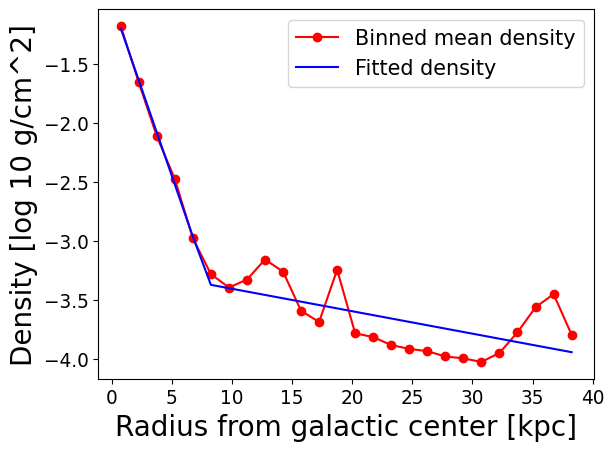

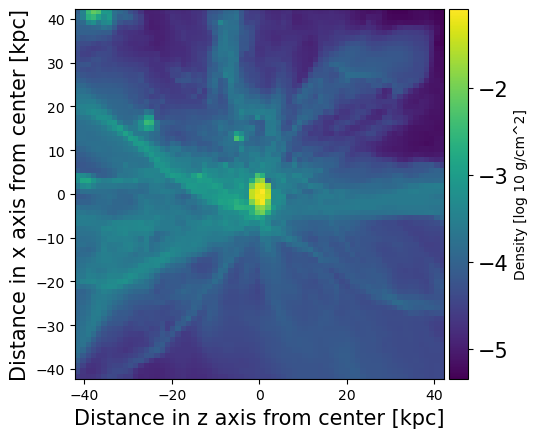

yt : [INFO     ] 2023-07-19 14:12:16,292 Parameters: current_time              = 242.56652781829
yt : [INFO     ] 2023-07-19 14:12:16,293 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 14:12:16,293 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 14:12:16,294 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 14:12:16,295 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-19 14:12:16,295 Parameters: current_redshift          = 1.1918720434881
yt : [INFO     ] 2023-07-19 14:12:16,295 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-19 14:12:16,296 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-19 14:12:16,297 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-19 14:12:16,297 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0838/DD0838
get_refine_box: using this location:      col1       col2    col3     col4     col5    col6     col7   col8
------------- ------- -------- -------- ------- -------- -------- ----
1.19187204349 0.49185 0.483393 0.503033 0.49385 0.485393 0.505033    9


Parsing Hierarchy : 100%|█████████████████| 6414/6414 [00:00<00:00, 7494.00it/s]
yt : [INFO     ] 2023-07-19 14:12:17,420 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 14:13:42,017 Projection completed
yt : [INFO     ] 2023-07-19 14:13:42,018 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


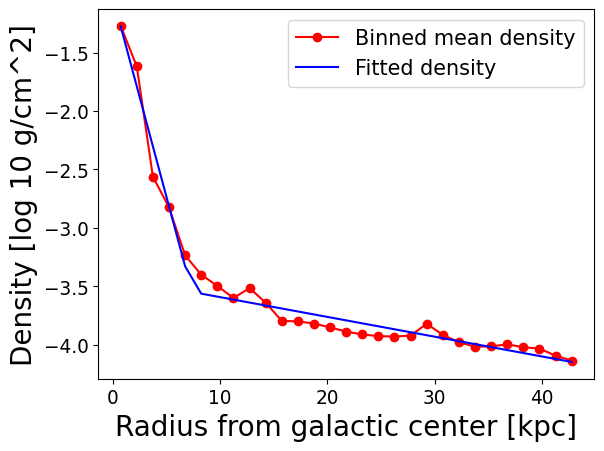

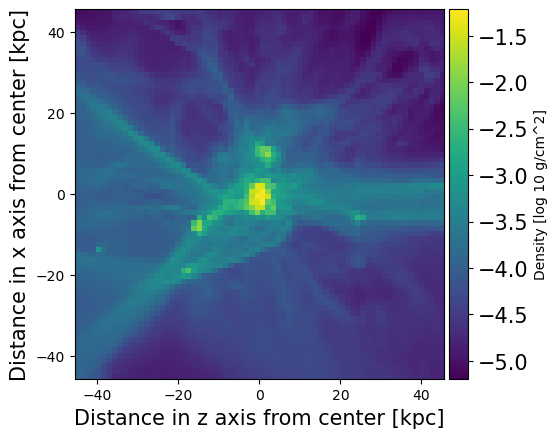

yt : [INFO     ] 2023-07-19 14:13:42,655 Parameters: current_time              = 267.56652781829
yt : [INFO     ] 2023-07-19 14:13:42,655 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 14:13:42,656 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 14:13:42,657 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 14:13:42,658 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-19 14:13:42,658 Parameters: current_redshift          = 1.0423765498971
yt : [INFO     ] 2023-07-19 14:13:42,659 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-19 14:13:42,660 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-19 14:13:42,660 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-19 14:13:42,661 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0938/DD0938
get_refine_box: using this location:     col1       col2     col3     col4     col5     col6     col7   col8
------------ -------- -------- -------- -------- -------- -------- ----
1.0423765499 0.491558 0.482256 0.503483 0.493558 0.484256 0.505483    9


Parsing Hierarchy : 100%|█████████████████| 6646/6646 [00:00<00:00, 6679.01it/s]
yt : [INFO     ] 2023-07-19 14:13:43,930 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 14:15:08,823 Projection completed
yt : [INFO     ] 2023-07-19 14:15:08,825 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


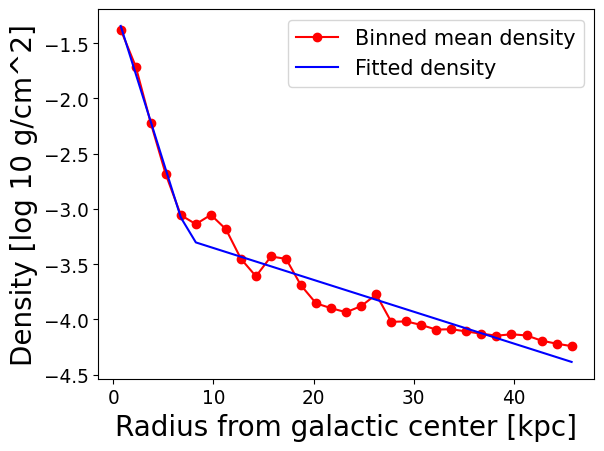

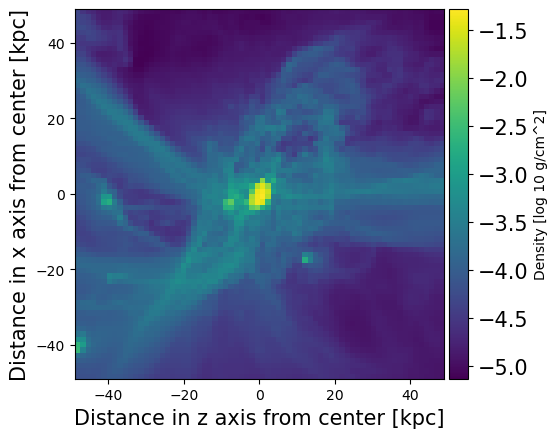

yt : [INFO     ] 2023-07-19 14:15:09,349 Parameters: current_time              = 292.31652781829
yt : [INFO     ] 2023-07-19 14:15:09,350 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 14:15:09,350 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 14:15:09,351 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 14:15:09,352 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-19 14:15:09,352 Parameters: current_redshift          = 0.91449134314195
yt : [INFO     ] 2023-07-19 14:15:09,353 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-19 14:15:09,354 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-19 14:15:09,355 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-19 14:15:09,355 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1038/DD1038
get_refine_box: using this location:      col1        col2     col3     col4     col5     col6     col7   col8
-------------- -------- -------- -------- -------- -------- -------- ----
0.914491343142 0.491324 0.481173 0.503918 0.493324 0.483173 0.505918    9


Parsing Hierarchy : 100%|█████████████████| 5369/5369 [00:00<00:00, 6652.49it/s]
yt : [INFO     ] 2023-07-19 14:15:10,773 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 14:16:23,878 Projection completed
yt : [INFO     ] 2023-07-19 14:16:23,880 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


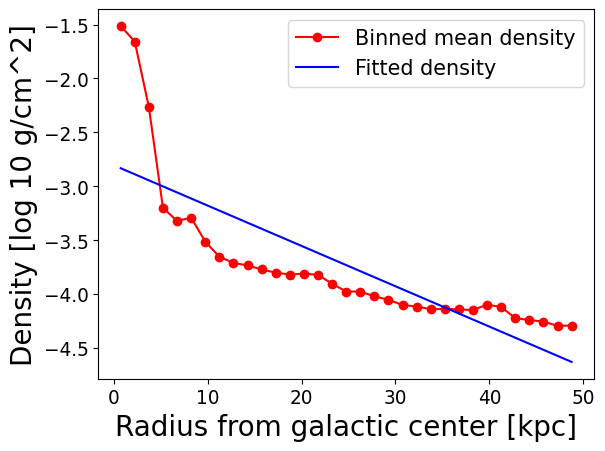

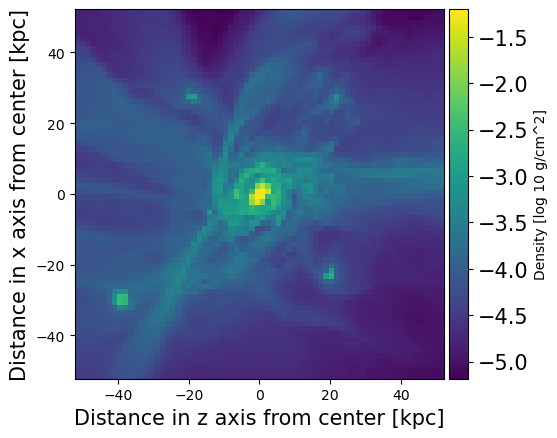

yt : [INFO     ] 2023-07-19 14:16:24,413 Parameters: current_time              = 317.31652781829
yt : [INFO     ] 2023-07-19 14:16:24,414 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 14:16:24,415 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 14:16:24,416 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 14:16:24,417 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-19 14:16:24,418 Parameters: current_redshift          = 0.80131183964773
yt : [INFO     ] 2023-07-19 14:16:24,419 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-19 14:16:24,419 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-19 14:16:24,420 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-19 14:16:24,421 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1138/DD1138
get_refine_box: using this location:       col1         col2    col3    col4     col5    col6    col7   col8
---------------- ------- ------- -------- ------- ------- -------- ----
0.80131183964773 0.49111 0.48016 0.504261 0.49311 0.48216 0.506261    9


Parsing Hierarchy : 100%|█████████████████| 5629/5629 [00:00<00:00, 8865.98it/s]
yt : [INFO     ] 2023-07-19 14:16:25,412 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 14:17:39,458 Projection completed
yt : [INFO     ] 2023-07-19 14:17:39,459 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


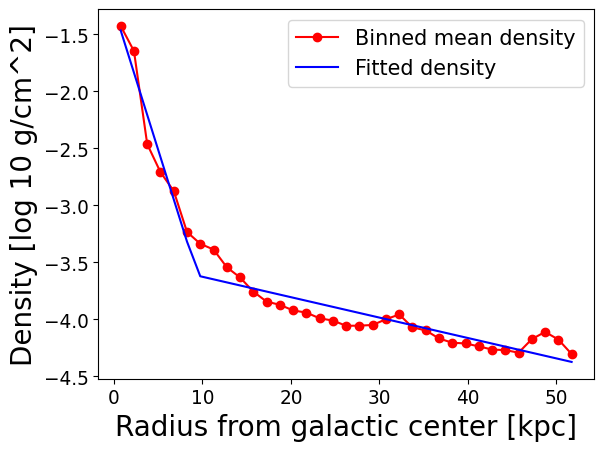

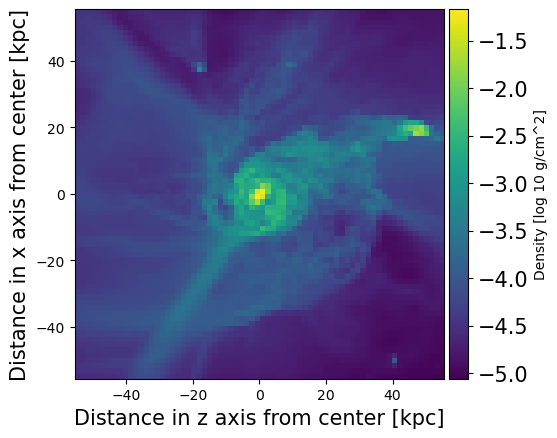

yt : [INFO     ] 2023-07-19 14:17:40,102 Parameters: current_time              = 342.31652781829
yt : [INFO     ] 2023-07-19 14:17:40,103 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 14:17:40,104 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 14:17:40,105 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 14:17:40,106 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-19 14:17:40,107 Parameters: current_redshift          = 0.70104740107777
yt : [INFO     ] 2023-07-19 14:17:40,108 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-19 14:17:40,109 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-19 14:17:40,109 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-19 14:17:40,110 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1238/DD1238
get_refine_box: using this location:       col1         col2    col3     col4     col5    col6     col7   col8
---------------- ------- -------- -------- ------- -------- -------- ----
0.70104740107777 0.49091 0.479176 0.504679 0.49291 0.481176 0.506679    9


Parsing Hierarchy : 100%|█████████████████| 6009/6009 [00:00<00:00, 7227.58it/s]
yt : [INFO     ] 2023-07-19 14:17:41,182 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 14:18:57,793 Projection completed
yt : [INFO     ] 2023-07-19 14:18:57,794 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


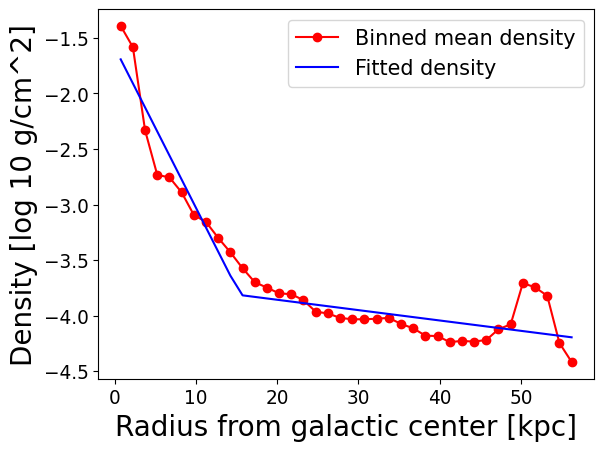

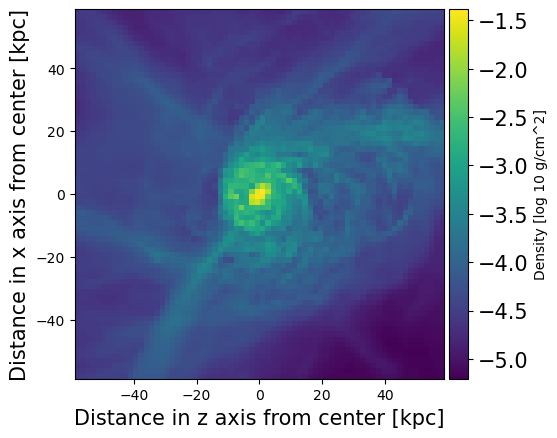

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1338/DD1338


yt : [INFO     ] 2023-07-19 14:18:58,640 Parameters: current_time              = 367.31652781829
yt : [INFO     ] 2023-07-19 14:18:58,641 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 14:18:58,642 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 14:18:58,642 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 14:18:58,643 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-19 14:18:58,644 Parameters: current_redshift          = 0.61132831909135
yt : [INFO     ] 2023-07-19 14:18:58,645 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-19 14:18:58,645 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-19 14:18:58,646 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-19 14:18:58,647 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3    col4     col5     col6    col7   col8
---------------- -------- ------- -------- -------- ------- -------- ----
0.61132831909135 0.490681 0.47823 0.505093 0.492681 0.48023 0.507093    9


Parsing Hierarchy : 100%|█████████████████| 6366/6366 [00:00<00:00, 7819.99it/s]
yt : [INFO     ] 2023-07-19 14:18:59,819 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 14:20:18,625 Projection completed
yt : [INFO     ] 2023-07-19 14:20:18,627 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


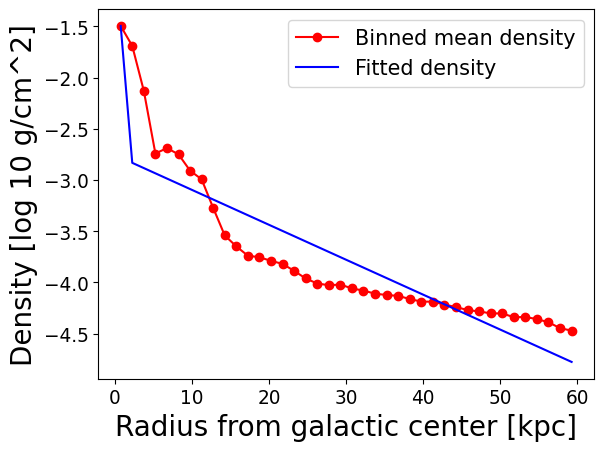

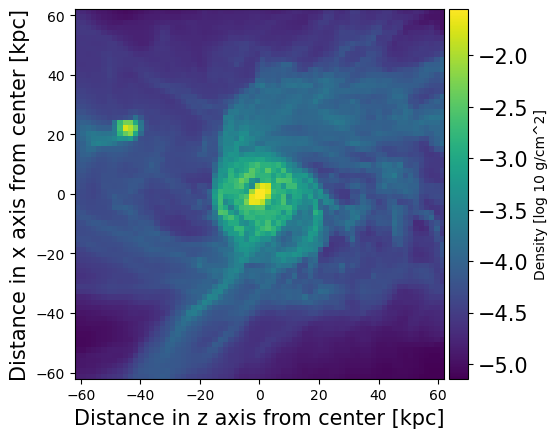

yt : [INFO     ] 2023-07-19 14:20:19,263 Parameters: current_time              = 392.31652781829
yt : [INFO     ] 2023-07-19 14:20:19,263 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 14:20:19,264 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 14:20:19,265 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 14:20:19,266 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-19 14:20:19,267 Parameters: current_redshift          = 0.53034842583426
yt : [INFO     ] 2023-07-19 14:20:19,267 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-19 14:20:19,268 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-19 14:20:19,269 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-19 14:20:19,269 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1438/DD1438
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.53034842583426 0.490464 0.477354 0.505497 0.492464 0.479354 0.507497    9


Parsing Hierarchy : 100%|█████████████████| 6029/6029 [00:00<00:00, 6517.63it/s]
yt : [INFO     ] 2023-07-19 14:20:20,431 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 14:21:36,471 Projection completed
yt : [INFO     ] 2023-07-19 14:21:36,472 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


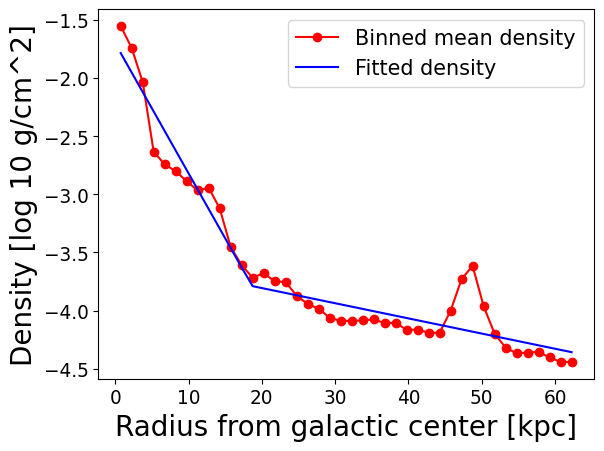

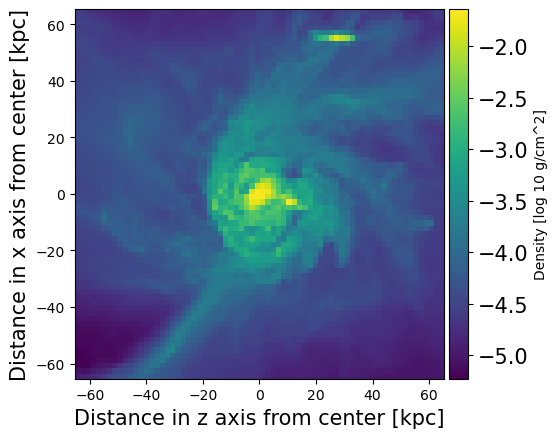

yt : [INFO     ] 2023-07-19 14:21:37,681 Parameters: current_time              = 402.06652781829
yt : [INFO     ] 2023-07-19 14:21:37,682 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 14:21:37,683 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 14:21:37,683 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 14:21:37,685 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-19 14:21:37,685 Parameters: current_redshift          = 0.50082158855578
yt : [INFO     ] 2023-07-19 14:21:37,686 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-19 14:21:37,686 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-19 14:21:37,687 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-19 14:21:37,688 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1477/DD1477
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.50082158855578 0.490382 0.477019 0.505663 0.492382 0.479019 0.507663    9


Parsing Hierarchy : 100%|█████████████████| 6066/6066 [00:00<00:00, 7987.29it/s]
yt : [INFO     ] 2023-07-19 14:21:38,693 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 14:22:59,242 Projection completed
yt : [INFO     ] 2023-07-19 14:22:59,244 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


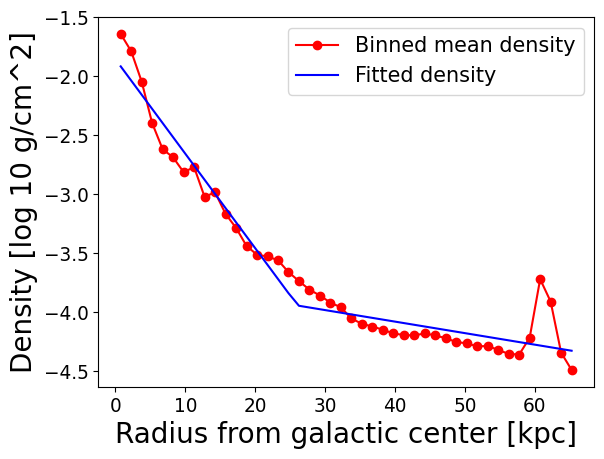

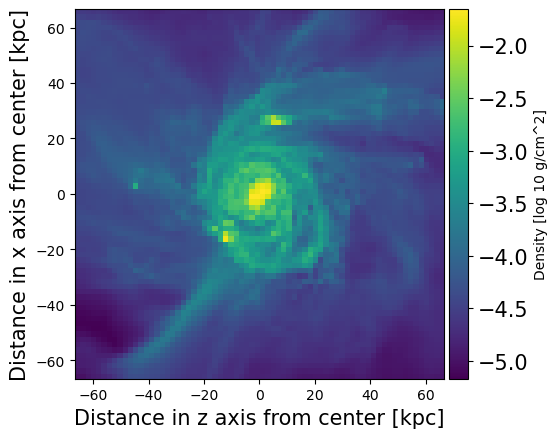

yt : [INFO     ] 2023-07-19 14:23:00,039 Parameters: current_time              = 402.31652781829
yt : [INFO     ] 2023-07-19 14:23:00,040 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 14:23:00,041 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 14:23:00,042 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 14:23:00,042 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-19 14:23:00,043 Parameters: current_redshift          = 0.50007848881181
yt : [INFO     ] 2023-07-19 14:23:00,044 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-19 14:23:00,044 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-19 14:23:00,045 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-19 14:23:00,046 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1478/DD1478
get_refine_box: using this location:       col1         col2    col3     col4     col5    col6     col7   col8
---------------- ------- -------- -------- ------- -------- -------- ----
0.50007848881181 0.49038 0.477011 0.505667 0.49238 0.479011 0.507667    9


Parsing Hierarchy : 100%|█████████████████| 5947/5947 [00:00<00:00, 8575.52it/s]
yt : [INFO     ] 2023-07-19 14:23:01,025 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 14:24:21,666 Projection completed
yt : [INFO     ] 2023-07-19 14:24:21,667 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


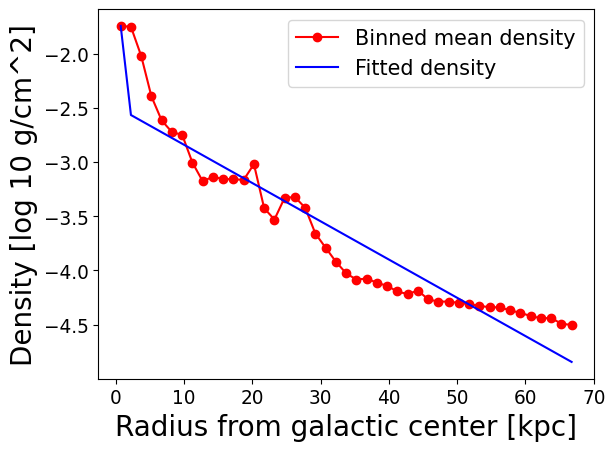

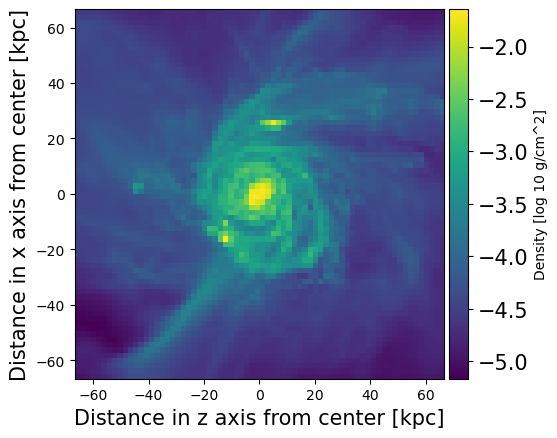

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1479/DD1479


yt : [INFO     ] 2023-07-19 14:24:22,835 Parameters: current_time              = 402.56652517609
yt : [INFO     ] 2023-07-19 14:24:22,836 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 14:24:22,836 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 14:24:22,837 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 14:24:22,838 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-19 14:24:22,839 Parameters: current_redshift          = 0.49933608114367
yt : [INFO     ] 2023-07-19 14:24:22,840 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-19 14:24:22,841 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-19 14:24:22,841 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-19 14:24:22,842 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.49933608114367 0.490378 0.477002 0.505671 0.492378 0.479002 0.507671    9


Parsing Hierarchy : 100%|█████████████████| 5985/5985 [00:00<00:00, 8138.97it/s]
yt : [INFO     ] 2023-07-19 14:24:23,833 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 14:25:43,980 Projection completed
yt : [INFO     ] 2023-07-19 14:25:43,982 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


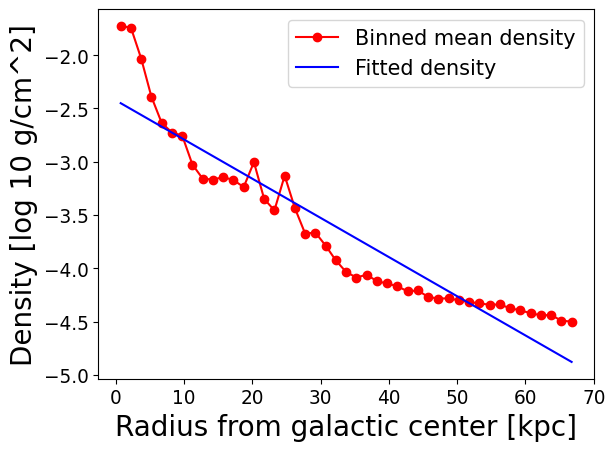

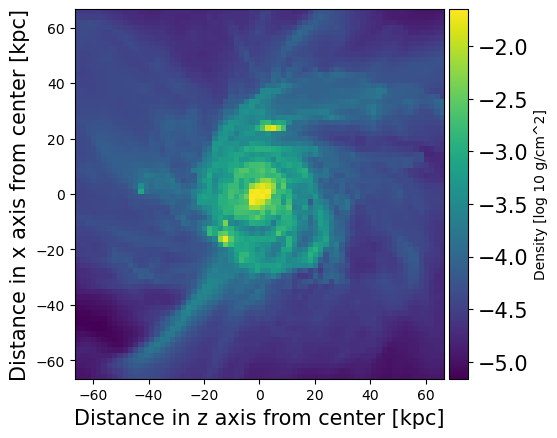

yt : [INFO     ] 2023-07-19 14:25:44,585 Parameters: current_time              = 417.31652781829
yt : [INFO     ] 2023-07-19 14:25:44,586 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 14:25:44,586 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 14:25:44,587 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 14:25:44,588 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-19 14:25:44,589 Parameters: current_redshift          = 0.45670560906839
yt : [INFO     ] 2023-07-19 14:25:44,589 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-19 14:25:44,590 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-19 14:25:44,590 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-19 14:25:44,591 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1538/DD1538
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.45670560906839 0.490252 0.476517 0.505875 0.492252 0.478517 0.507875    9


Parsing Hierarchy : 100%|█████████████████| 6119/6119 [00:00<00:00, 9232.06it/s]
yt : [INFO     ] 2023-07-19 14:25:45,482 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 14:27:03,964 Projection completed
yt : [INFO     ] 2023-07-19 14:27:03,965 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


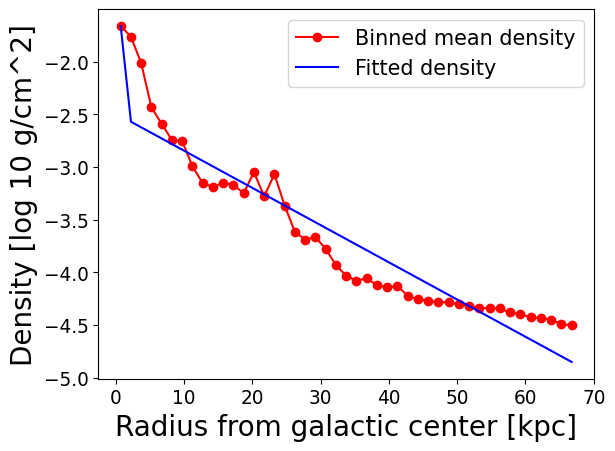

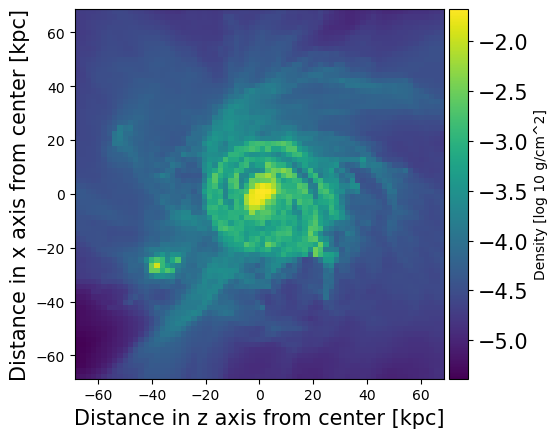

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1638/DD1638


yt : [INFO     ] 2023-07-19 14:27:04,677 Parameters: current_time              = 442.31652781829
yt : [INFO     ] 2023-07-19 14:27:04,678 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 14:27:04,679 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 14:27:04,680 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 14:27:04,680 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-19 14:27:04,681 Parameters: current_redshift          = 0.3892837031507
yt : [INFO     ] 2023-07-19 14:27:04,682 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-19 14:27:04,683 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-19 14:27:04,683 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-19 14:27:04,684 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.38929394169243 0.490071 0.475697 0.506226 0.492071 0.477697 0.508226    9


Parsing Hierarchy : 100%|█████████████████| 5613/5613 [00:00<00:00, 8309.91it/s]
yt : [INFO     ] 2023-07-19 14:27:05,600 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 14:28:16,434 Projection completed
yt : [INFO     ] 2023-07-19 14:28:16,436 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


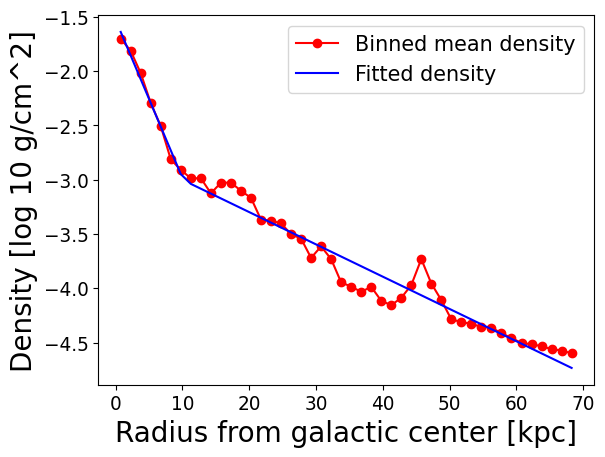

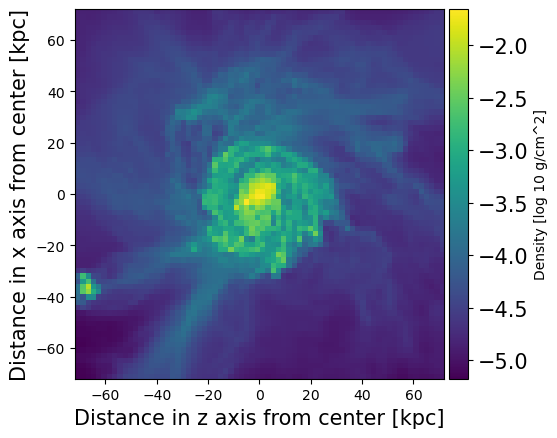

yt : [INFO     ] 2023-07-19 14:28:17,036 Parameters: current_time              = 467.31652781829
yt : [INFO     ] 2023-07-19 14:28:17,037 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 14:28:17,038 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 14:28:17,038 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 14:28:17,039 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-19 14:28:17,040 Parameters: current_redshift          = 0.32721407621449
yt : [INFO     ] 2023-07-19 14:28:17,040 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-19 14:28:17,041 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-19 14:28:17,042 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-19 14:28:17,043 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1738/DD1738
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.32722883488872 0.489878 0.474896 0.506564 0.491878 0.476896 0.508564    9


Parsing Hierarchy : 100%|█████████████████| 5309/5309 [00:00<00:00, 6267.01it/s]
yt : [INFO     ] 2023-07-19 14:28:18,114 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 14:29:24,097 Projection completed
yt : [INFO     ] 2023-07-19 14:29:24,098 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


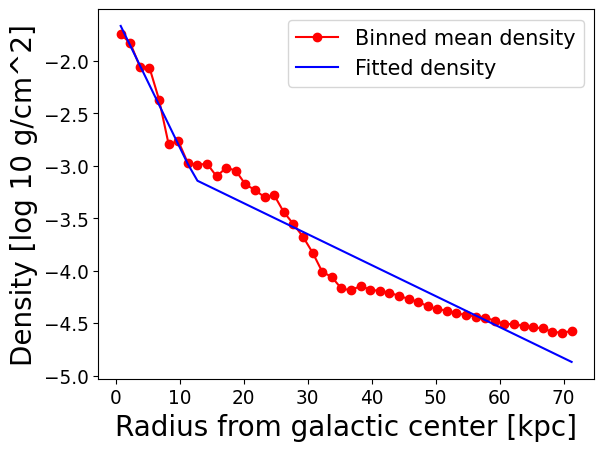

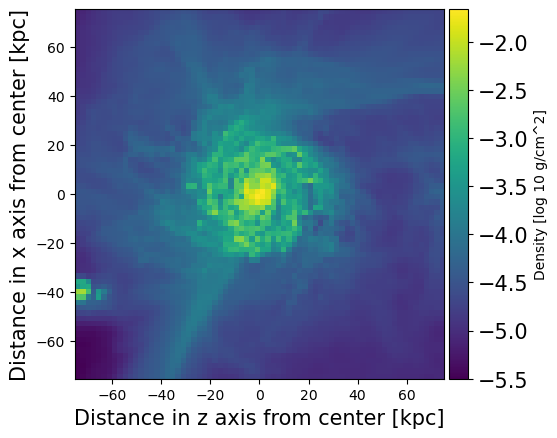

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1838/DD1838


yt : [INFO     ] 2023-07-19 14:29:24,814 Parameters: current_time              = 492.31652781829
yt : [INFO     ] 2023-07-19 14:29:24,815 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 14:29:24,816 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 14:29:24,817 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 14:29:24,818 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-19 14:29:24,819 Parameters: current_redshift          = 0.26978215732692
yt : [INFO     ] 2023-07-19 14:29:24,820 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-19 14:29:24,821 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-19 14:29:24,822 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-19 14:29:24,822 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1        col2     col3     col4     col5     col6     col7   col8
--------------- -------- -------- -------- -------- -------- -------- ----
0.2697939304999 0.489703 0.474121 0.506863 0.491703 0.476121 0.508863    9


Parsing Hierarchy : 100%|█████████████████| 5365/5365 [00:00<00:00, 6456.69it/s]
yt : [INFO     ] 2023-07-19 14:29:25,888 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 14:30:33,713 Projection completed
yt : [INFO     ] 2023-07-19 14:30:33,715 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


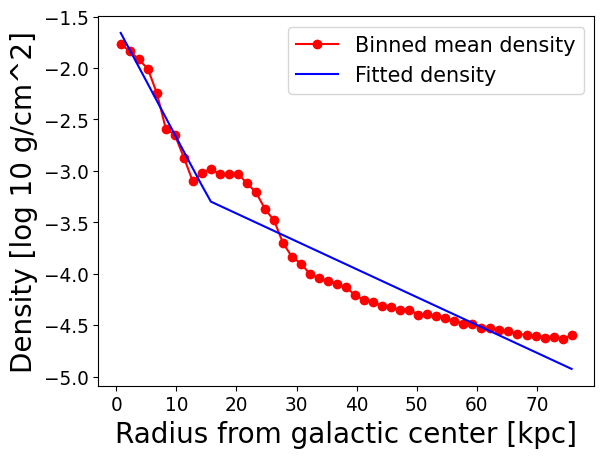

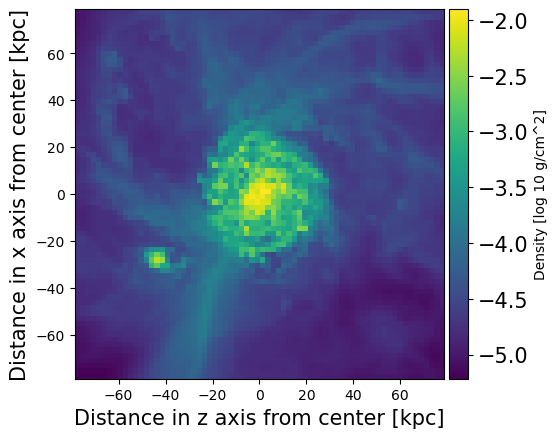

yt : [INFO     ] 2023-07-19 14:30:34,331 Parameters: current_time              = 517.31652781829
yt : [INFO     ] 2023-07-19 14:30:34,332 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 14:30:34,332 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 14:30:34,333 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 14:30:34,334 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-19 14:30:34,335 Parameters: current_redshift          = 0.21639444449422
yt : [INFO     ] 2023-07-19 14:30:34,336 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-19 14:30:34,336 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-19 14:30:34,337 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-19 14:30:34,337 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1938/DD1938
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.21640266677445 0.489548 0.473393 0.507161 0.491548 0.475393 0.509161    9


Parsing Hierarchy : 100%|█████████████████| 4944/4944 [00:00<00:00, 6215.79it/s]
yt : [INFO     ] 2023-07-19 14:30:35,365 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 14:31:39,349 Projection completed
yt : [INFO     ] 2023-07-19 14:31:39,351 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


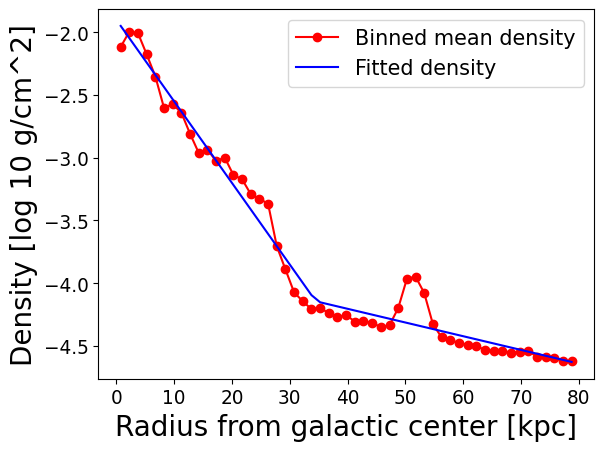

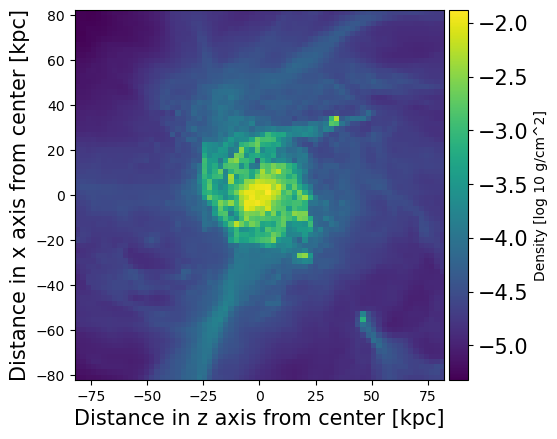

yt : [INFO     ] 2023-07-19 14:31:40,476 Parameters: current_time              = 542.31652781829
yt : [INFO     ] 2023-07-19 14:31:40,477 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 14:31:40,477 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 14:31:40,478 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 14:31:40,479 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-19 14:31:40,480 Parameters: current_redshift          = 0.1665627895111
yt : [INFO     ] 2023-07-19 14:31:40,481 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-19 14:31:40,482 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-19 14:31:40,482 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-19 14:31:40,483 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2038/DD2038
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.16656997024797 0.489403 0.472708 0.507468 0.491403 0.474708 0.509468    9


Parsing Hierarchy : 100%|█████████████████| 5224/5224 [00:00<00:00, 7559.69it/s]
yt : [INFO     ] 2023-07-19 14:31:41,416 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 14:32:46,625 Projection completed
yt : [INFO     ] 2023-07-19 14:32:46,627 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


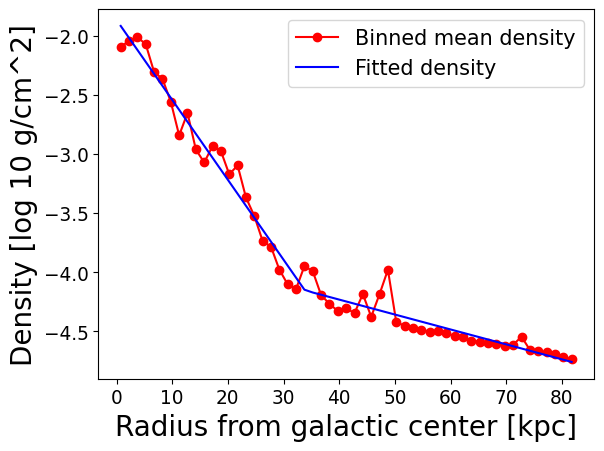

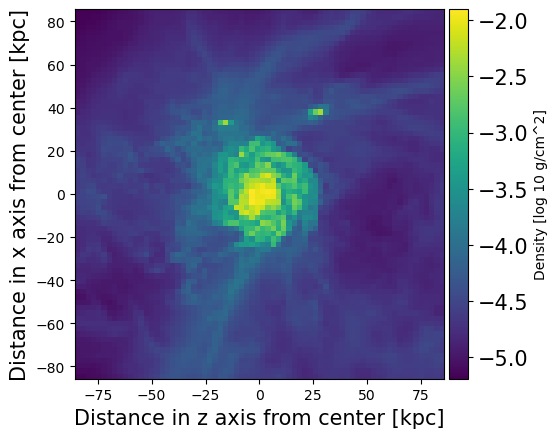

yt : [INFO     ] 2023-07-19 14:32:47,382 Parameters: current_time              = 567.31652781829
yt : [INFO     ] 2023-07-19 14:32:47,383 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 14:32:47,384 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 14:32:47,385 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 14:32:47,386 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-19 14:32:47,386 Parameters: current_redshift          = 0.11988207020675
yt : [INFO     ] 2023-07-19 14:32:47,387 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-19 14:32:47,387 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-19 14:32:47,388 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-19 14:32:47,389 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2138/DD2138
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.11989107535193 0.489254 0.472056 0.507771 0.491254 0.474056 0.509771    9


Parsing Hierarchy : 100%|█████████████████| 4682/4682 [00:00<00:00, 7711.88it/s]
yt : [INFO     ] 2023-07-19 14:32:48,236 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 14:33:48,089 Projection completed
yt : [INFO     ] 2023-07-19 14:33:48,091 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


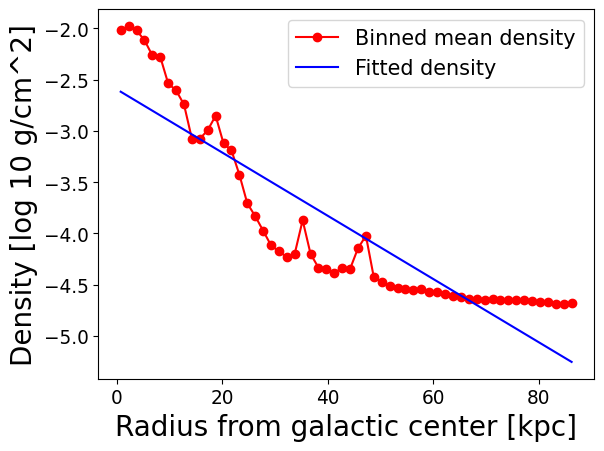

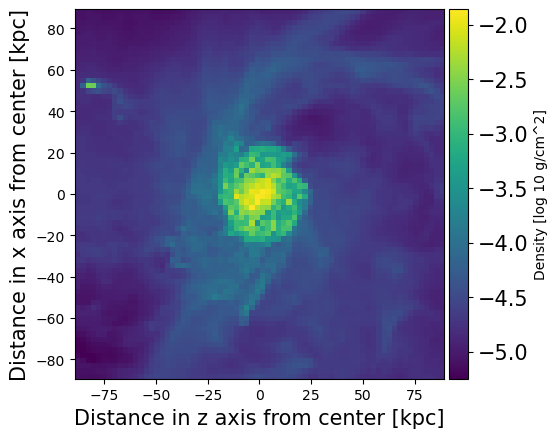

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2238/DD2238


yt : [INFO     ] 2023-07-19 14:33:48,838 Parameters: current_time              = 592.31652781829
yt : [INFO     ] 2023-07-19 14:33:48,839 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 14:33:48,840 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 14:33:48,841 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 14:33:48,841 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-19 14:33:48,842 Parameters: current_redshift          = 0.076013204837093
yt : [INFO     ] 2023-07-19 14:33:48,842 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-19 14:33:48,843 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-19 14:33:48,843 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-19 14:33:48,844 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:        col1         col2     col3     col4     col5     col6     col7   col8
----------------- -------- -------- -------- -------- -------- -------- ----
0.076025451160672 0.489123 0.471432 0.508053 0.491123 0.473432 0.510053    9


Parsing Hierarchy : 100%|█████████████████| 4688/4688 [00:00<00:00, 6285.74it/s]
yt : [INFO     ] 2023-07-19 14:33:49,810 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 14:34:49,648 Projection completed
yt : [INFO     ] 2023-07-19 14:34:49,649 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hylee/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
yt : [INFO     ] 2023-07-19 14:34:49,764 Parameters: current_time              = 604.81652781829
yt : [INFO     ] 2023-07-19 14:34:49,765 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 14:34:49,765 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 14:34:49,766 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 14:34:49,767 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07

Error with DD2238
Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2288/DD2288
get_refine_box: using this location:        col1         col2     col3     col4     col5     col6     col7   col8
----------------- -------- -------- -------- -------- -------- -------- ----
0.055055663741937 0.489056 0.471131 0.508189 0.491056 0.473131 0.510189    9


Parsing Hierarchy : 100%|█████████████████| 4745/4745 [00:00<00:00, 7662.33it/s]
yt : [INFO     ] 2023-07-19 14:34:50,592 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 14:35:55,932 Projection completed
yt : [INFO     ] 2023-07-19 14:35:55,934 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


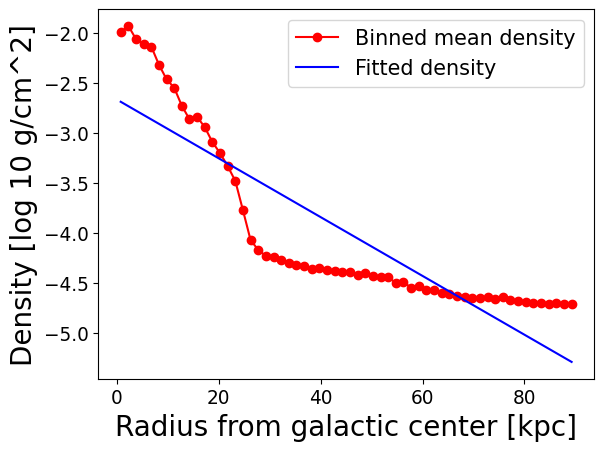

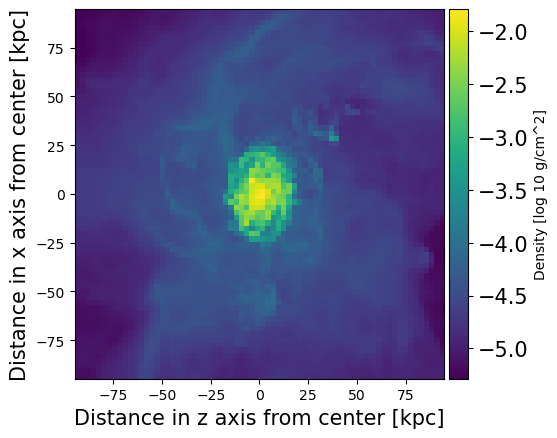

yt : [INFO     ] 2023-07-19 14:35:56,501 Parameters: current_time              = 605.06652781829
yt : [INFO     ] 2023-07-19 14:35:56,502 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 14:35:56,502 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 14:35:56,504 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 14:35:56,505 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-19 14:35:56,505 Parameters: current_redshift          = 0.054634911934635
yt : [INFO     ] 2023-07-19 14:35:56,506 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-19 14:35:56,507 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-19 14:35:56,508 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-19 14:35:56,509 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2289/DD2289
get_refine_box: using this location:        col1         col2     col3     col4     col5     col6     col7   col8
----------------- -------- -------- -------- -------- -------- -------- ----
0.054642475638284 0.489054 0.471125 0.508191 0.491054 0.473125 0.510191    9


Parsing Hierarchy : 100%|█████████████████| 4798/4798 [00:00<00:00, 6724.28it/s]
yt : [INFO     ] 2023-07-19 14:35:57,669 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 14:37:03,079 Projection completed
yt : [INFO     ] 2023-07-19 14:37:03,081 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


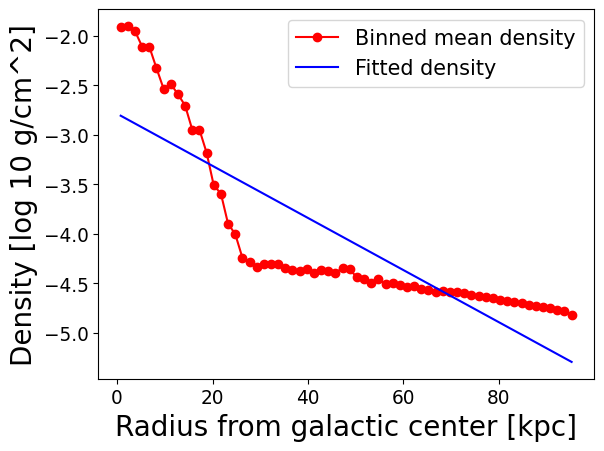

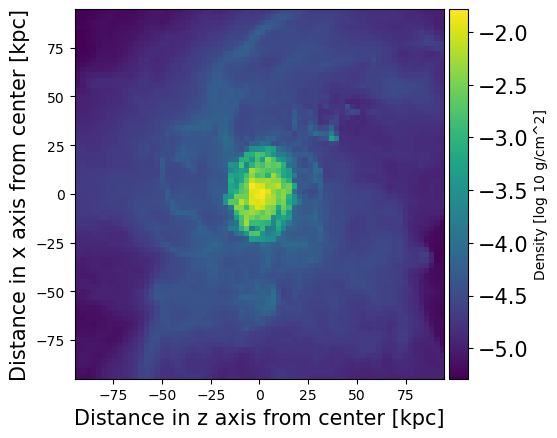

yt : [INFO     ] 2023-07-19 14:37:03,700 Parameters: current_time              = 617.31652781829
yt : [INFO     ] 2023-07-19 14:37:03,701 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 14:37:03,702 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 14:37:03,703 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 14:37:03,704 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-19 14:37:03,704 Parameters: current_redshift          = 0.034670076640073
yt : [INFO     ] 2023-07-19 14:37:03,705 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-19 14:37:03,705 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-19 14:37:03,706 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-19 14:37:03,707 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2338/DD2338
get_refine_box: using this location:        col1         col2     col3     col4    col5     col6     col7  col8
----------------- -------- -------- ------- -------- -------- ------- ----
0.034684446722936 0.488987 0.470833 0.50832 0.490987 0.472833 0.51032    9


Parsing Hierarchy : 100%|█████████████████| 4505/4505 [00:00<00:00, 6002.67it/s]
yt : [INFO     ] 2023-07-19 14:37:04,661 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 14:38:04,058 Projection completed
yt : [INFO     ] 2023-07-19 14:38:04,060 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


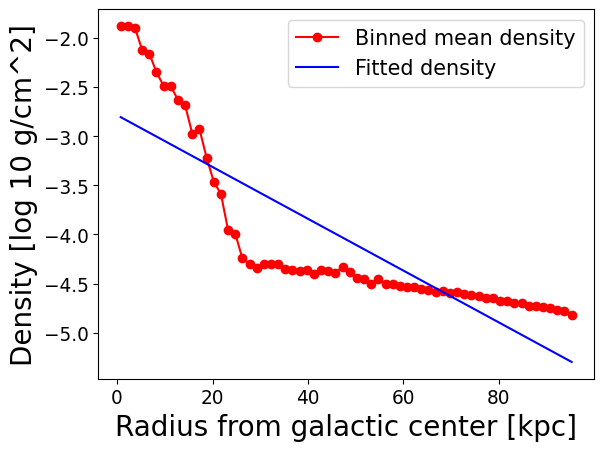

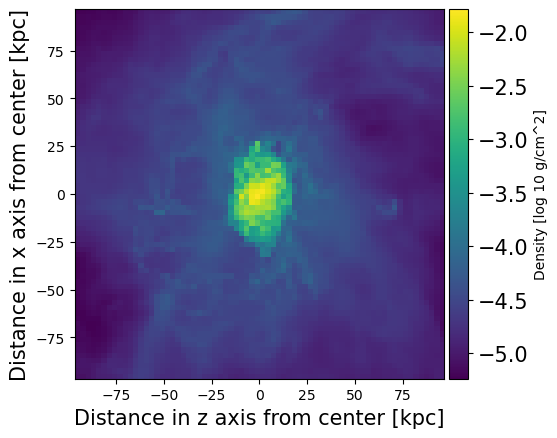

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2427/DD2427


yt : [INFO     ] 2023-07-19 14:38:04,963 Parameters: current_time              = 639.44480357087
yt : [INFO     ] 2023-07-19 14:38:04,964 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-19 14:38:04,965 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-19 14:38:04,967 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-19 14:38:04,969 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-19 14:38:04,971 Parameters: current_redshift          = 0
yt : [INFO     ] 2023-07-19 14:38:04,972 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-19 14:38:04,973 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-19 14:38:04,974 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-19 14:38:04,975 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:         col1          col2     col3     col4    col5     col6     col7  col8
------------------- -------- -------- ------- -------- -------- ------- ----
4.4408920985006e-16 0.488865 0.470316 0.50854 0.490865 0.472316 0.51054    9


Parsing Hierarchy : 100%|█████████████████| 4262/4262 [00:00<00:00, 6009.18it/s]
yt : [INFO     ] 2023-07-19 14:38:05,899 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-19 14:39:02,307 Projection completed
yt : [INFO     ] 2023-07-19 14:39:02,308 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


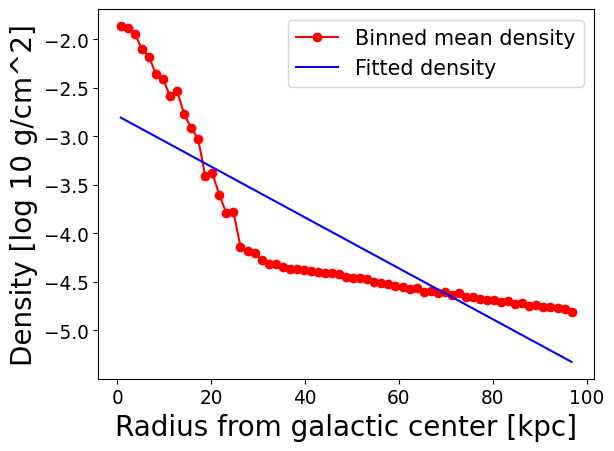

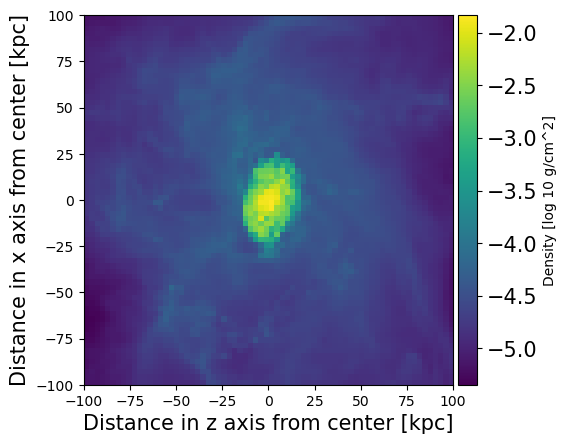

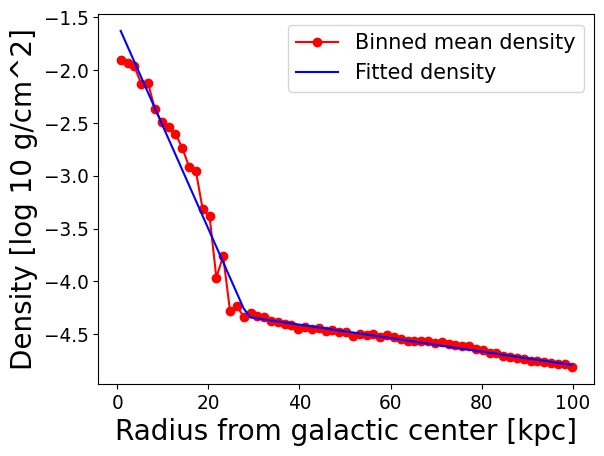

In [9]:
redshiftlist = [] #This part will be replaced with pandas later. 
cutofflist = [] #same 
timelist = [] #same 

for DD in sorted_dd_list:
    try:  
        snap = DD  # name of the snapshot output 
        snap_fullpath = simulation_dir + snap + '/' + snap # full path of where the snapshot output lives

        ds, refine_box = foggie_load(snap_fullpath, track_name, halo_c_v_name=track_dir + 'halo_c_v',
                                  disk_relative=False, do_filter_particles=False, masses_dir=track_dir)
        
        z = ds.get_parameter("CosmologyCurrentRedshift")
        width = 200/(1+z) #[ckpc/h]
        max_radius = width/2 #[ckpc/h]
        
        #Density cutoff part should be here. 
    
        frb = frb_projection(ds, field, axis, refine_box, width, resolution, weight_field = None)

        OD_Rad, OD_Qua = radius_func(np.array(frb["gas",field]), width, resolution)

        radiuslist, quantitylist =  binning_func(OD_Rad, OD_Qua, max_radius, min_radius, binsize)
        
        
        p , e = optimize.curve_fit(piecewise_linear, radiuslist, np.log10(quantitylist))
        #p : popt(optimization parameter) / e : pcov(covariance of popt)

        projection_plot = projection(frb, field, width, colorlabel, axis, fontsize = 15)
        segment_plot = plotting(radiuslist, np.log10(quantitylist), piecewise_linear(radiuslist, *p),
                        'ro-','b-', plotlabel_linedot, plotlabel_segment)
 
        segment_plot.savefig(output_dir + snap + "_Density_Profile.jpg", bbox_inches = 'tight')
        projection_plot.savefig(output_dir + snap + "_Density_Projection_Plot.jpg")
    
        timepara = ds.current_time.in_units('Gyr').value + 0
        redshiftlist.append(z) #[z]
        cutofflist.append(p[0]) #[kpc]
        timelist.append(timepara) #[Gyr]
        
    except:
        print("Error with" +" "+ snap)
        pass     

In [10]:
#pandadata = {'Rdshift' : redshiftlist, 'Current time' : timelist, 'Cut-off radius' : cutofflist}
#Pd_dataframe = pd.DataFrame(data=d)
#Pd_dataframe4

Text(0, 0.5, 'Redshift [z]')

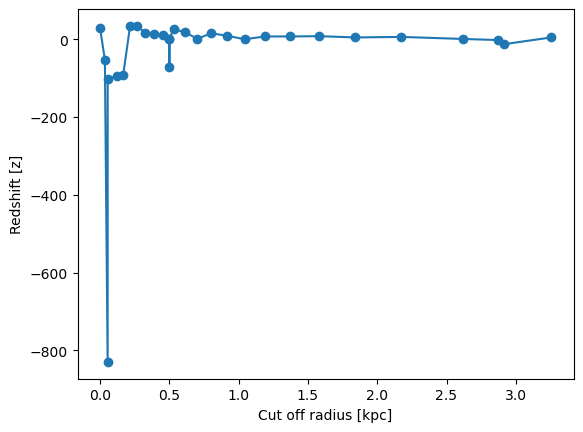

In [11]:
plt.plot(redshiftlist, cutofflist,'-o')
plt.xlabel("Cut off radius [kpc]")
plt.ylabel("Redshift [z]")